# Project - Cdiscount Image Classification



# Data ingestion
The primary training set is a 57GB bson file, having ~15 Million images (180x180 images in Base64 format) of ~7.06 Million products. We have imported the dataset into a MongoDB instance on a VPS, so we were able to query among the records.
We have chosen 100 categories, which overally consist of ~246K images of ~110K products.


## Dataset preparation

First we need to ensure that the "gdown" library is installed and accessible in the environment and download the train_medium data from Google Drive,

In [36]:
#! pip install gdown && gdown --id 1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1

## Note for the team
Since the original dataset is pretty large, I've created a subset file containing ~250K photos in 100 categories, but it is still so large that it may not fit into the memory, so I've used the below parameters to load a fitable subset accordingly, please read the comments of each variable careflully, and do not change the loading code please, just set the values of the parameters.

In [37]:
import pandas as pd

import base64
from PIL import Image
import base64
import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Run the cell below if you have a gpu that you want to use

In [38]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Load your data

In [39]:
CONVERT_TO_NP_ARRAY= False   # Wether convert the Base64 string to (180,180,3) arrays or keep the Base64 string.

REPLACE_BASE64_SPECIAL_CHARS = True # If you have the base64 decoding layer in your model, 
                                    # you need to set this to True to replace the two special characters in Base64 that is incompatible with tf image reader

LOADING_MODE = "all" 
                             # num_records: Loads the first NUM_RECORDS in the dataset and calculates NUM_CATEGORIES dynamically
                             # num_categories: Loads first NUM_CATEGORIES and calculates NUM_RECORDS dynamically
                             # all: Loads all the 250K images, ignores all parameters below
                            
    
NUM_RECORDS = 3000           # Only used when the mode is set to num_records
NUM_CATEGORIES = 10           # Only used when the mode is set to num_category
MAX_RECORDS_PER_CATEGORY = 0 # if not zero, will ensure that there is no more per category in the dataframe, won't work when mode is set to all

In [40]:
def get_array_from_base64(img, shape=(180,180,3)):
    return np.array(
        Image.open(
            io.BytesIO(
                base64.b64decode(
                    img.replace('_', '/').replace('-', '+') if REPLACE_BASE64_SPECIAL_CHARS else img
                )
            )
        )
    ).reshape(shape)


In [41]:
FILE_NAME= "train_shuffled_100cat.csv"
header = 3

df = pd.read_csv(FILE_NAME, header=3, nrows=0)

if LOADING_MODE == "all":
    df = pd.read_csv(FILE_NAME, header=header)

if LOADING_MODE == "num_records":
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=min(NUM_RECORDS, 100))
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if MAX_RECORDS_PER_CATEGORY:
            for cat in df["category_id"].unique():
                if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                    removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                    df = df.drop(removed_rows.index)
        if df.shape[0]>=NUM_RECORDS:
            df = df.head(NUM_RECORDS)
            break
    
elif LOADING_MODE == "num_categories": 
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=100)
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if df["category_id"].nunique() > NUM_CATEGORIES:
            break
    if MAX_RECORDS_PER_CATEGORY:
        for cat in df["category_id"].unique():
            if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                df = df.drop(removed_rows.index)

    cat_removed = df["category_id"].unique()[NUM_CATEGORIES:]
    df = df.loc[~df['category_id'].isin(cat_removed)]
    NUM_RECORDS= df.shape[0]

if CONVERT_TO_NP_ARRAY:        
    df["image"] = df["image"].apply(
                    lambda x: get_array_from_base64(x)
                )
if REPLACE_BASE64_SPECIAL_CHARS:
    df["image"] = df["image"].apply(
                    lambda x: x.replace('/', '_').replace('+', '-')
                )
    
NUM_CATEGORIES = df['category_id'].nunique()

categories = df['category_id'].unique()
categories.sort()
category_id_map = {k: v for v, k in enumerate(categories)}
df["class"] = df["category_id"].apply(lambda x: category_id_map[x])

print("Num records:", NUM_RECORDS)
print("Num categories:", NUM_CATEGORIES)
print("Training df shape:", df.shape)
print("Mem used by images:", int(sum(df["image"].apply(lambda x: x.nbytes if type(x)!=str else len(x))/10 ** 6)), "MB")
# print(len(df.at[0, "image"]))

Num records: 3000
Num categories: 99
Training df shape: (246261, 4)
Mem used by images: 1613 MB


In [42]:
rdf = df.sample(frac=1, random_state=123)
rdf.reset_index(drop=True, inplace=True)


In [43]:
X_dev = np.stack(rdf["image"]) if CONVERT_TO_NP_ARRAY else np.array(rdf["image"])
Y_dev = np.array(rdf["class"])
print(X_dev.shape,Y_dev.shape, Y_dev[-10:])


(246261,) (246261,) [18 45 86 50 70 44 62 15 18 14]


## 2. Explore your data 

Showing 10 samples from dev set

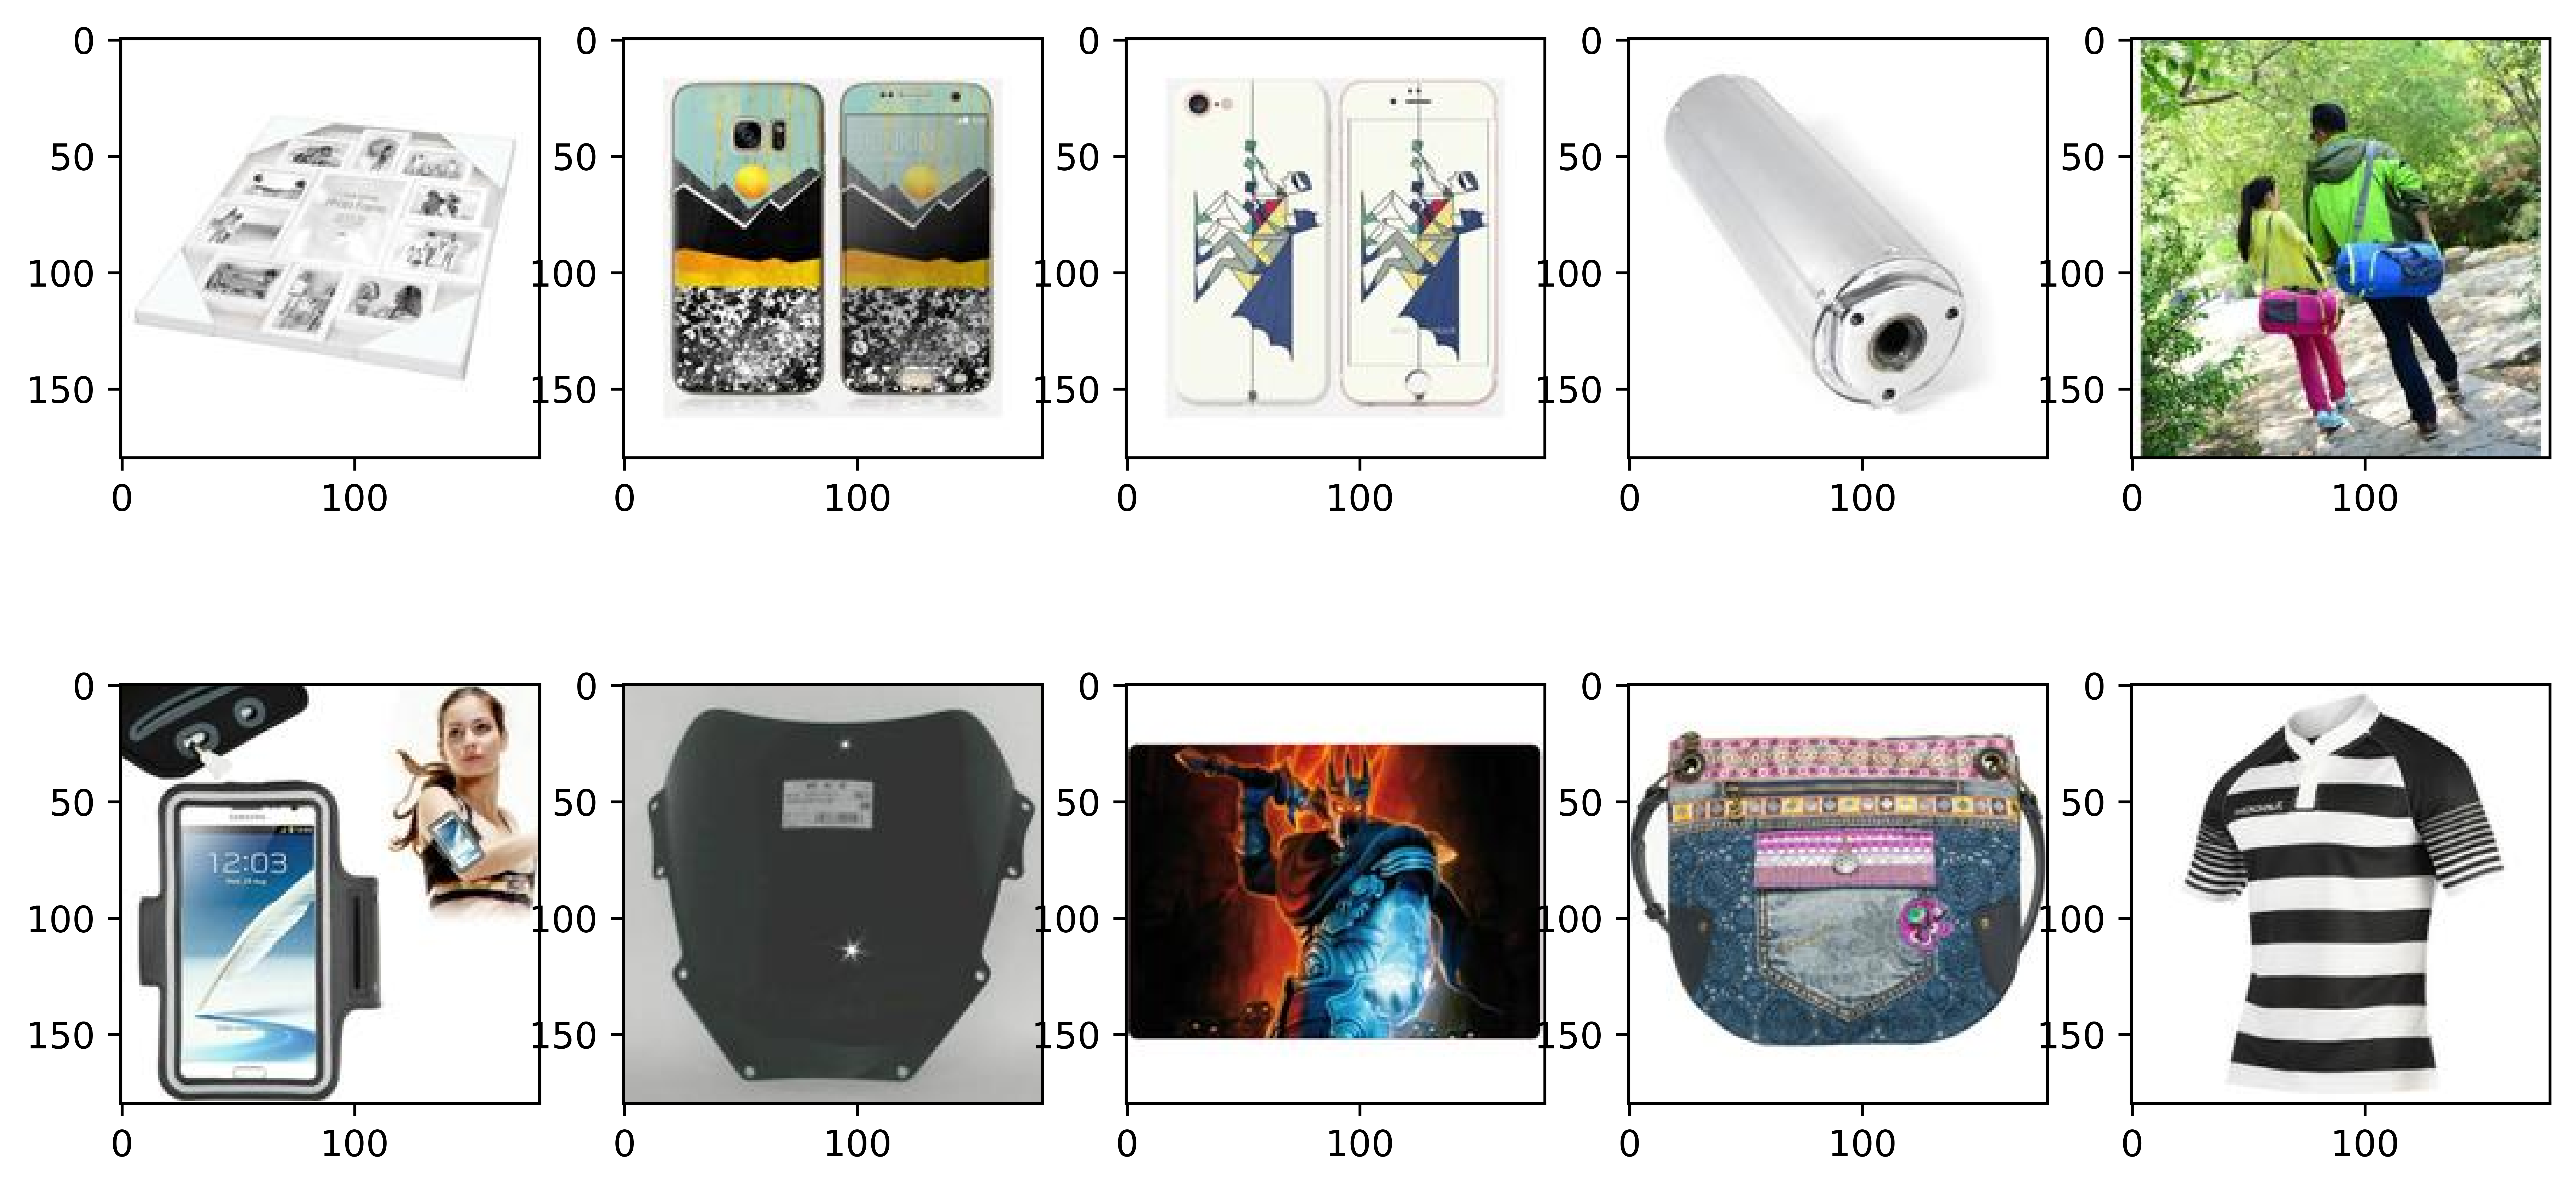

In [44]:
plt.figure(figsize=(12, 6), dpi=1000)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.title("Labeled %d" % Y_dev[idx])
  plt.imshow(X_dev[idx] if CONVERT_TO_NP_ARRAY else get_array_from_base64(X_dev[idx]))
plt.show()

#Splitting dev set into train/val set

In [45]:
num_train = int(len(X_dev) * .75) #= splitting point of train/val set
num_val = int(len(X_dev) * .2)
num_test = len(X_dev) - num_train - num_val

X_train = X_dev[:num_train]
Y_train = Y_dev[:num_train]

X_val = X_dev[num_train:-num_test]
Y_val = Y_dev[num_train:-num_test]

X_test = X_dev[-num_test:]
Y_test = Y_dev[-num_test:]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (184695,)
X_val: (49252,)
X_test: (12314,)


## 3. Represent your labels using one hot encoding

In [46]:
# Y_train_oh = tf.keras.utils.to_categorical(Y_train)
# Y_val_oh = tf.keras.utils.to_categorical(Y_val)
# Y_test_oh = tf.keras.utils.to_categorical(Y_test)


# print("Y_train",  Y_train[:3])
# print("Y_train_oh:",  Y_train_oh[:3])


# print("TRAIN:", X_train.shape, Y_train.shape, Y_train_oh.shape)
# print("VAL:", X_val.shape, Y_val.shape, Y_val_oh.shape)
# print("TEST:", X_test.shape, Y_test.shape, Y_test_oh.shape)

## 4. Data scaling and Data augmentation

### Preprocess_and_decode:
It is a function which applies to each image input to the model, it first decodes the JPEG base64 encoded image to a tensor, then it scales it based on the sample's min, max, mean and std.
Since we are normalizing our data per sample, our normalization is row-wise and a column-wise normalization is not yet an option. We can do this by preprocessing our dataset by batching it if that seemed necessary. 

In [47]:
def preprocess_and_decode(img_str, new_shape=(180,180), scaling_mode = 2 ): #scaling_mode= 0: disabled, 1: min-max normalization, 2: standardization
    img = tf.io.decode_base64(img_str)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, new_shape, method=tf.image.ResizeMethod.BILINEAR)
   
    if scaling_mode == 1: 
      img_min = tf.math.reduce_min(img, axis=None, keepdims=False, name=None)
      img_max = tf.math.reduce_max(img, axis=None, keepdims=False, name=None)
      img = ( img - img_min ) / (img_max - img_min)
      
    elif scaling_mode == 2:
      img_mean = tf.math.reduce_mean(img, axis=None, keepdims=False, name=None)
      img_std = tf.math.reduce_std(img, axis=None, keepdims=False, name=None)
      img = ( img - img_mean ) / img_std
      
    return img


### About data augmentation
Since our dataset consist of 2-4 image per product, and we have over 2K images per category, data augmentation seems unnecessary.
I still have not found a way to do data augmentation on Base64 strings(remember I moved to Base64-> tensor decoding inside the model itself to enable us to do batch training on the whole dataset), but if we come to a need for it, there is definitly a way to do that!

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [48]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape = (180,180,3), k = NUM_CATEGORIES, lr = 1e-3):
    input64 = tf.keras.layers.Input(shape=(1,), dtype="string")
    img_tensor = tf.keras.layers.Lambda(
        lambda img: tf.map_fn(lambda im: preprocess_and_decode(im[0]), img, dtype="float32"))(input64)
    l1 = tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation= 'relu')(img_tensor)
    l2 = tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation= 'relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)
    flat = tf.keras.layers.Flatten()(l6)
    out = tf.keras.layers.Dense(k, activation= 'softmax')(flat)
    model = tf.keras.models.Model(inputs = input64, outputs = out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'sparse_categorical_crossentropy', metrics= ["accuracy"])
    return model
model = my_model_cnn()
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 64)        1849

## 6. Define your callbacks (save your model, patience, etc.)

In [49]:
from time import time; 
model_name_cnn = "cdiscount_CCN_all_{}.h5".format(int(time()))

print("Saving model: {}".format(model_name_cnn))
# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

Saving model: cdiscount_CCN_all_1615419126.h5


## 7. Train your model

In [ ]:
# train your model - decide for how many epochs
model.fit(X_train,Y_train,batch_size = 16, epochs = 150, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val))


Epoch 1/150
11544/11544 [==============================] - 454s 39ms/step - loss: 3.3596 - accuracy: 0.1682 - val_loss: 3.4787 - val_accuracy: 0.1373
Epoch 2/150
11544/11544 [==============================] - 472s 41ms/step - loss: 3.4224 - accuracy: 0.1386 - val_loss: 3.4868 - val_accuracy: 0.1373
Epoch 3/150
11544/11544 [==============================] - 412s 36ms/step - loss: 3.4210 - accuracy: 0.1385 - val_loss: 3.4639 - val_accuracy: 0.1373
Epoch 4/150
 1262/11544 [==>...........................] - ETA: 4:43 - loss: 3.4382 - accuracy: 0.1361

## 8. Test your model

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(get_array_from_base64(X_test[wrong_indexes[jj]]), cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()